In [35]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [10]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [11]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

In [12]:
from helper__3stays_v3_scripts import get_clusters_x

In [13]:
event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

In [14]:
time_thresh = 1/6
dist_thresh=0.25

In [15]:
stays = get3(2, 0.5)
#stays = get1()

In [16]:
time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

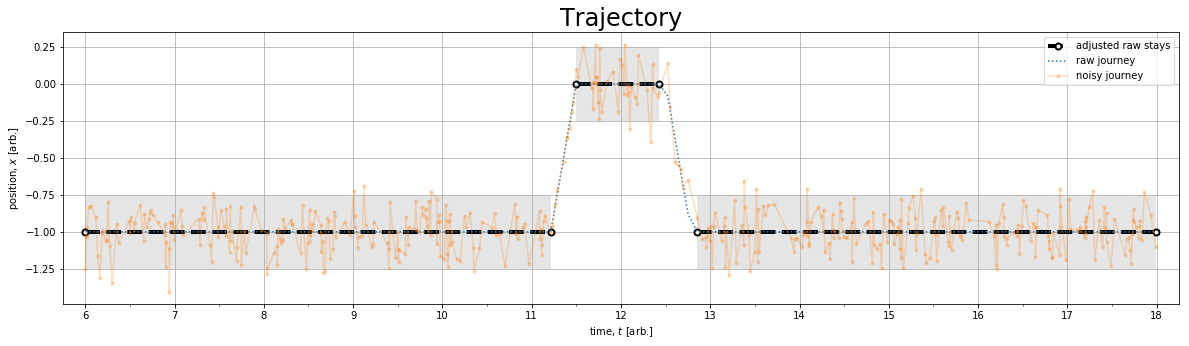

In [17]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [18]:
from helper__3stays_v3_scripts import plot_cluster_boxplots

In [19]:
from helper__metric_box__explore import eval_synth_data

## Development

In [20]:
from helper__gaps import merge_clusters

In [21]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

### Early gap-method

### Later gap method

In [22]:
from helper__gaps import get_intercluster_metrics

In [23]:
from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2

In [24]:
from helper__metric_box__explore import iqr_metrics, get_iqr, get_iqr_mask

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

In [25]:
from helper__3stays_v3_scripts import extend_cluster, intersecting_bounds, extend_final_clusters

In [26]:
from helper__3stays_v3_scripts import _extend_edge, get_iqr_mask_x, get_bounded_events

In [27]:
from stay_classification.box_classifier.box_method import get_time_ind
#get_mask, make_box, get_directional_indices, get_thresh_mean, check_means, 

In [28]:
from helper__metric_box__explore import extend_cluster, extend_clusters, extend_edge

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. 

In [45]:
subcluster_lengths = lambda cluster_list: [len(c) for c in cluster_list]

In [46]:
clusters = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh)
clusters_rev = get_clusters_x(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')

print("\t", len(clusters), 'clusters:', subcluster_lengths(clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print("\t", len(clusters_rev), 'clusters:', subcluster_lengths(clusters_rev))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)


new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print("\t", len(new_clusters), 'clusters:', subcluster_lengths(new_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print("\t", len(new_clusters_rev), 'clusters:', subcluster_lengths(new_clusters_rev))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)


new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_2)
print('forward')
print("\t", len(new_clusters_2), 'clusters:', subcluster_lengths(new_clusters_2))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev_2)
print('backward')
print("\t", len(new_clusters_rev_2), 'clusters:', subcluster_lengths(new_clusters_rev_2))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

forward
	 31 clusters: [7, 5, 17, 2, 28, 2, 3, 39, 6, 7, 9, 16, 35, 4, 11, 7, 2, 3, 5, 4, 14, 2, 3, 7, 50, 2, 17, 27, 11, 5, 14]
	 0.973
	 0.834

backward
	 41 clusters: [8, 13, 11, 2, 51, 2, 2, 9, 3, 3, 20, 15, 2, 2, 14, 4, 4, 5, 2, 2, 3, 5, 2, 2, 4, 2, 22, 2, 16, 16, 3, 7, 5, 8, 5, 6, 35, 11, 20, 3, 3]
	 0.964
	 0.806
forward
	 10 clusters: [200, 4, 30, 5, 4, 14, 2, 3, 113, 34]
	 0.976
	 0.934

backward
	 10 clusters: [200, 4, 30, 5, 4, 14, 2, 3, 113, 34]
	 0.976
	 0.934
forward
	 4 clusters: [200, 44, 4, 186]
	 0.975
	 0.991

backward
	 4 clusters: [200, 30, 3, 197]
	 0.970
	 0.977


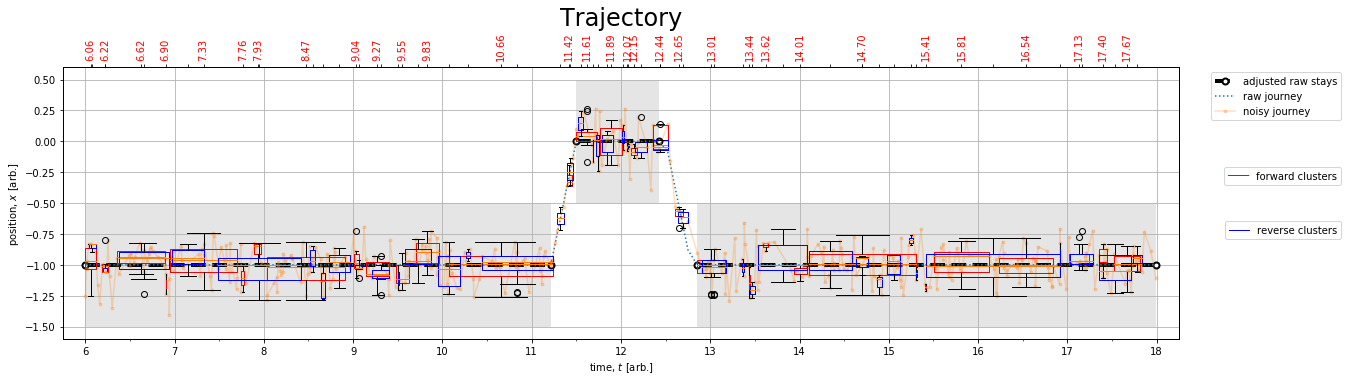

In [48]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs);

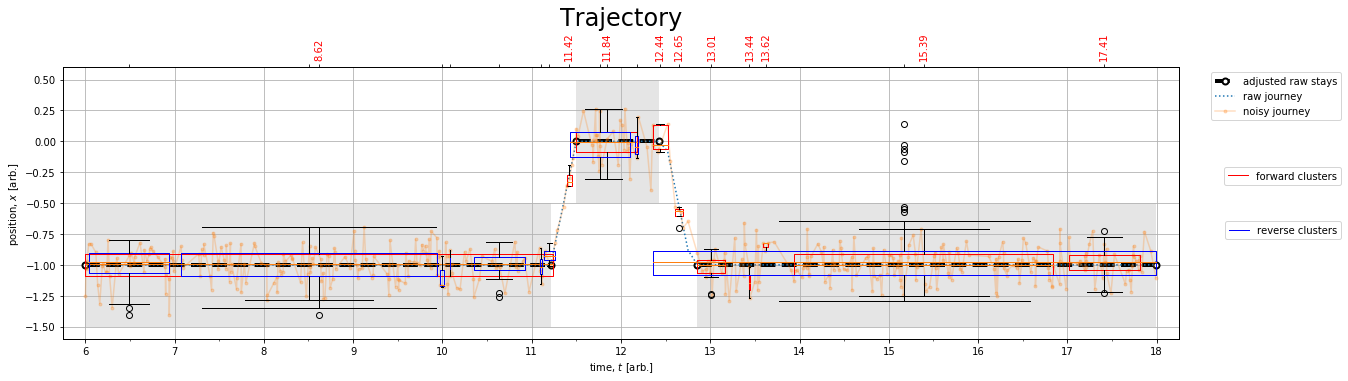

In [36]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters, new_clusters_rev, configs);

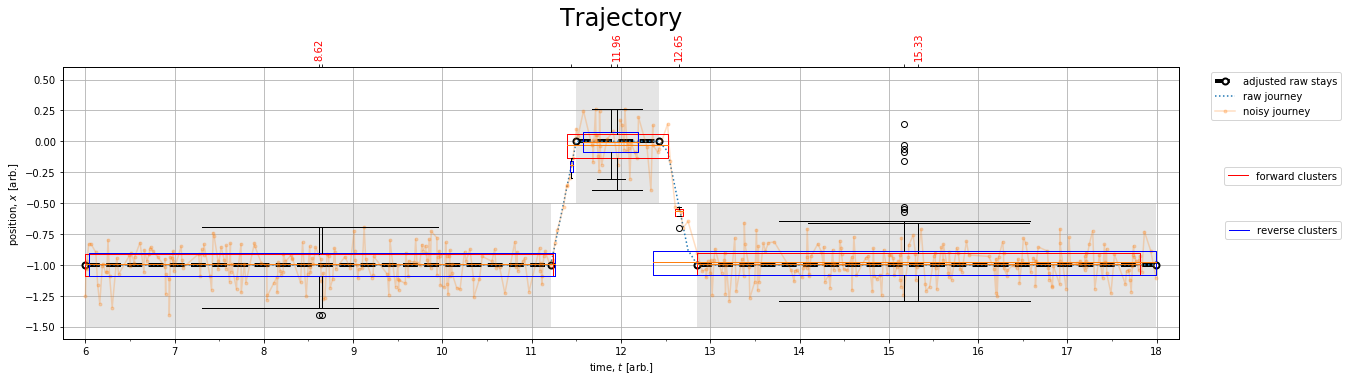

In [37]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, new_clusters_rev_2, configs);

In [61]:
# Get only those indices which occur in both for-/back-wards sets;
# --> store to a single set of clusters
# NOTE: the bias is towards the backwards set of clusters
total_mindices = []
for c in new_clusters_2:
    # get those indices which define the IQR of a cluster
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    # ... and save them flattened
    total_mindices.extend(mask[0].tolist())

total_mindices_rev = []
final_clusters_rev = []
for c in new_clusters_rev_2:
    # get those indices which define the IQR of a cluster    
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices)))
    total_mindices_rev.extend(cluster)
    if len(cluster)>5:        
        final_clusters_rev.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices_rev)

In [62]:
# Get only those indices which occur in both for-/back-wards sets;
# --> store to a single set of clusters
# NOTE: the bias is towards the backwards set of clusters
total_mindices_rev = []
for c in new_clusters_rev_2:
    # get those indices which define the IQR of a cluster
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    # ... and save them flattened
    total_mindices_rev.extend(mask[0].tolist())

total_mindices = []
final_clusters = []
for c in new_clusters_2:
    # get those indices which define the IQR of a cluster    
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices_rev)))
    total_mindices.extend(cluster)
    if len(cluster)>5:
        final_clusters.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices)

In [63]:
len(final_clusters), len(final_clusters_rev)

(3, 3)

In [64]:
for c1,c2 in zip(final_clusters,final_clusters_rev):
    
    if (len(c1)>1) and (len(c2)>1):
        print(f"c1: {len(c1):4d}: [{c1[0]:4d},{c1[-1]:4d}] and c2: {len(c2):4d}: [{c2[0]:4d},{c2[-1]:4d}]")
    elif (len(c1)>1):
        print(f"c1: {len(c1):4d}: [{c1[0]:4d},{c1[-1]:4d}] and c2: {len(c2):4d}: [    ,    ]")
    elif (len(c2)>1):
        print(f"c1: {len(c1):4d}: [    ,    ] and c2: {len(c2):4d}: [{c2[0]:4d},{c2[-1]:4d}]")
    else:
        print(f"c1: {len(c1):4d}: [    ,    ] and c2: {len(c2):4d}: [    ,    ]")
        

c1:  100: [   1, 199] and c2:  100: [   1, 199]
c1:   15: [ 207, 236] and c2:   14: [ 207, 232]
c1:   89: [ 253, 438] and c2:   89: [ 253, 438]


In [112]:
#0 2 0 1 -1.090931663933738 -0.9091706185993363
get_iqr_mask_x(noise_arr[0:2], 0, (noise_arr[final_clusters[0]].min(), noise_arr[final_clusters[0]].max()), 0, True)[0]

(-1.090931663933738, -0.9091706185993363)


array([1])

In [191]:
from helper__3stays_v3_scripts import get_extended_clusters

In [195]:
final_extended_clusters = get_extended_clusters(time_arr, noise_arr, final_clusters, time_thresh, True)

Cluster #0
	length: 100, bounds: [-1.091, -0.909]
Backwards
	1.1. [   1,  199], new:    0, last:    1
	1.2. [   1,    1], new:    0, last:    1
Forwards
	2.1. [   1, 199], new:  209, last:  199
	2.2. [   1, 199], new:  209, last:  199
	 1 199 209 199
Final cluster: length =   98; range = [   1, 199], 209

Cluster #1
	length: 15, bounds: [-0.133,  0.049]
Backwards
	1.1. [ 207,  236], new:  196, last:  207
Forwards
	2.1. [ 207, 236], new:  245, last:  236
	2.2. [ 209, 244], new:  245, last:  236
	 209 244 245 236
		not = [ 209,  244], new:  245, last:  236
	2.2. [ 209, 245], new:  251, last:  244
	 209 245 251 244
		not = [ 209,  245], new:  251, last:  244
	2.2. [ 209, 245], new:  252, last:  245
	 209 245 252 245
Final cluster: length =   20; range = [ 209, 245], 252

Cluster #2
	length: 89, bounds: [-1.076, -0.906]
Backwards
	1.1. [ 253,  438], new:  246, last:  253
Forwards
	2.1. [ 253, 438], new:  442, last:  438
	2.2. [ 254, 439], new:  442, last:  438
	 254 439 442 438
		not = [ 2

In [150]:
final_extended_clusters

[[1,
  2,
  3,
  9,
  10,
  11,
  12,
  16,
  17,
  18,
  19,
  21,
  22,
  24,
  26,
  27,
  31,
  32,
  33,
  35,
  38,
  39,
  40,
  42,
  44,
  45,
  46,
  49,
  55,
  56,
  58,
  59,
  63,
  64,
  69,
  73,
  74,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  93,
  95,
  96,
  97,
  98,
  100,
  101,
  103,
  107,
  112,
  113,
  114,
  117,
  118,
  120,
  121,
  123,
  125,
  126,
  127,
  129,
  133,
  139,
  140,
  141,
  143,
  144,
  149,
  150,
  152,
  155,
  156,
  158,
  162,
  165,
  168,
  169,
  173,
  178,
  179,
  181,
  182,
  185,
  187,
  188,
  189,
  192,
  193,
  196,
  198,
  199],
 [0.04874845031102765,
  209.0,
  211.0,
  212.0,
  215.0,
  216.0,
  218.0,
  219.0,
  222.0,
  224.0,
  229.0,
  231.0,
  232.0,
  233.0,
  235.0,
  236.0,
  238.0,
  240.0,
  243.0,
  244.0,
  245.0],
 [-0.9059532002574877,
  254.0,
  255.0,
  257.0,
  258.0,
  259.0,
  261.0,
  263.0,
  264.0,
  267.0,
  271.0,
  275.0,
  286.0,
  288.0,
  289.0,
  291.0,
  292.0

(5.5, 18.25)

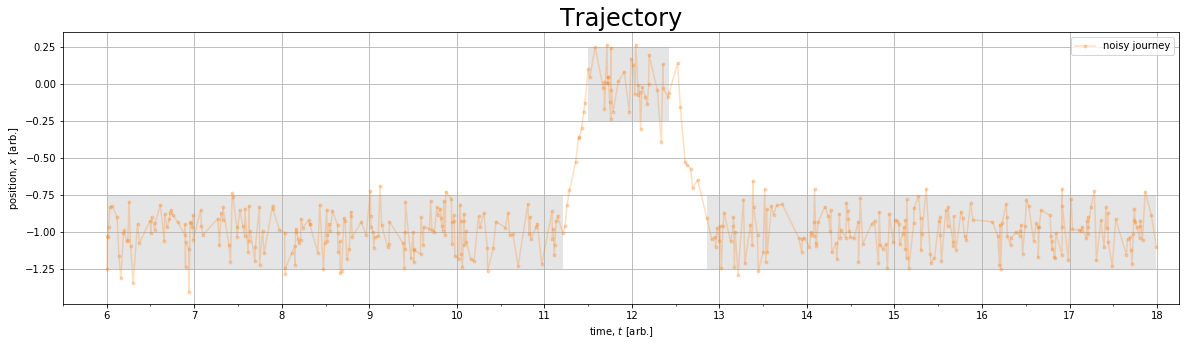

In [98]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [79]:
prec, rec, conmat = eval_synth_data(segments, time_arr, final_extended_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.964
 0.991
[[  0  16]
 [  4 423]]


In [80]:
int((len(segments)+1)/2)

3

In [81]:
from helper__3stays_v3_scripts import eval_synth_data_clusters

0 0 198
0 1 199
[0, 199]
0.9949748743718593 0.9949748743718593
2 208 245
1 1 245
[1, 245]
0.15510204081632653 1.0
4 253 442
2 1 439
[1, 442]
0.42596810933940776 0.9842105263157894


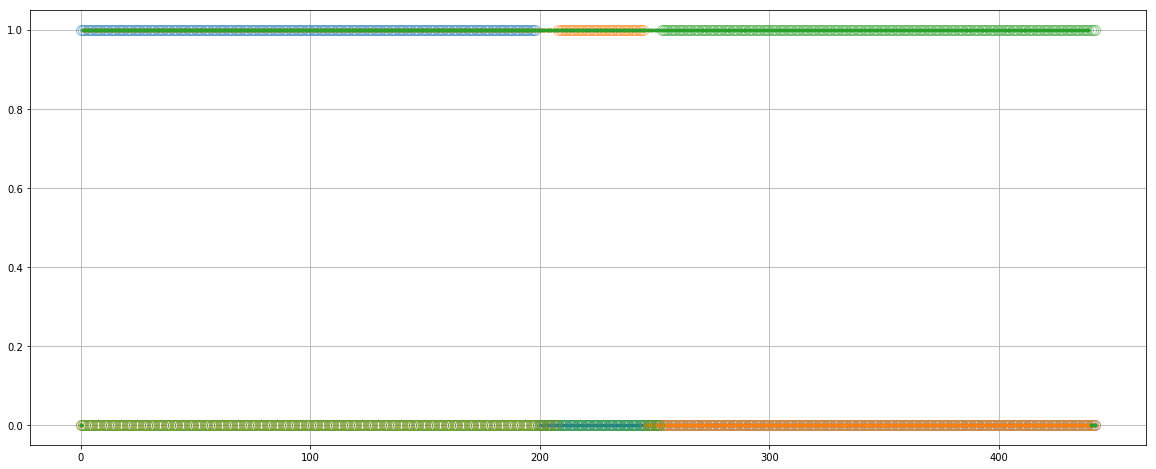

In [82]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays
from sklearn.metrics import precision_score, recall_score, confusion_matrix
    
    
expected_nr_of_stays = int((len(segments)+1)/2)

fig, ax = plt.subplots(figsize=[20,8])
color='C0'

colors = ['C0','C1','C2']

for n in range(0,len(segments),2):
    
    true_indices = get_stay_indices(get_adjusted_stays(segments[n:n+1], time_arr), time_arr)[0]    
    print(n, true_indices[0], true_indices[-1])
    
    nn = int(n/2)
    clust = final_extended_clusters[nn]
    print(nn, clust[0], clust[-1])    
    
    pair = [min(true_indices[0],clust[0]), max(true_indices[-1],clust[-1])]
    print(pair)
    
    true_labels = np.zeros(time_arr.shape)
    true_labels[true_indices[0]:true_indices[1]+1] = 1
        
        
    pred_labels = np.zeros(time_arr.shape)
    pred_labels[clust[0]:clust[-1]+1] = 1      
    
 
    prec = precision_score(true_labels, pred_labels)
    rec  = recall_score(true_labels, pred_labels)        
    
    color = colors[nn]
    ax.plot(true_labels, 'o', markersize=10, color=color, markerfacecolor='None', alpha=0.5)
    ax.plot(pred_labels, '.', color=color)

    print(prec, rec)
    #break

plt.grid()    

In [ ]:
from helper__3stays_v3_scripts import get_no_overlap

In [ ]:
ultimate_clusters = get_no_overlap(time_arr, final_extended_clusters.copy())

In [ ]:
get_uniqs = lambda clusts: [print(len(c), len(set(c))) for c in clusts]

In [ ]:
_ = get_uniqs(final_clusters)

In [ ]:
_ = get_uniqs(final_extended_clusters)

In [ ]:
_ = get_uniqs(ultimate_clusters)

In [ ]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')


for c in ultimate_clusters:

    ax.plot(time_arr[c], noise_arr[c], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [ ]:
prec, rec, conmat = eval_synth_data(segments, time_arr, ultimate_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)